In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [14]:
input_file = "C:/thaiduong/SocialNetwork/movie_dataset.csv"  # Thay đường dẫn đúng với file của bạn
data = pd.read_csv(input_file)
print(f"Dữ liệu có {data.shape[0]} hàng và {data.shape[1]} cột.")

# Xem thông tin chi tiết
print(data.info())

Dữ liệu có 1097 hàng và 18 cột.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Movie Title               1097 non-null   object
 1   Tomatometer               1091 non-null   object
 2   Popcornmeter              1088 non-null   object
 3   Director                  1097 non-null   object
 4   Producer                  1068 non-null   object
 5   Screenwriter              1052 non-null   object
 6   Distributor               980 non-null    object
 7   Production Co             1065 non-null   object
 8   Rating                    856 non-null    object
 9   Genre                     1096 non-null   object
 10  Original Language         1091 non-null   object
 11  Release Date (Theaters)   986 non-null    object
 12  Release Date (Streaming)  1063 non-null   object
 13  Box Office (Gross USA)    714 non-null    obje

In [15]:
data["Cast"] = data["Cast"].apply(lambda x: str(x).split(", "))
data["Genre"] = data["Genre"].apply(lambda x: str(x).split(", "))


# Remove director's name from 'Cast' column if it exists
data["Cast"] = data.apply(
    lambda row: [actor for actor in row["Cast"] if actor != row["Director"]], axis=1
)

In [16]:
# Loại bỏ ký hiệu % và chuyển thành số
data["Tomatometer"] = data["Tomatometer"].str.replace("%", "", regex=True).astype(float)
data["Popcornmeter"] = (
    data["Popcornmeter"].str.replace("%", "", regex=True).astype(float)
)


In [17]:
import re


# Hàm chuyển đổi thời lượng phim
def convert_runtime(runtime):
    if pd.isna(runtime):  # Kiểm tra nếu giá trị là NaN
        return None
    if isinstance(runtime, str):  # Kiểm tra nếu giá trị là chuỗi
        match = re.match(r"(\d+)h (\d+)m", runtime)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2))
            return hours * 60 + minutes
        elif re.match(r"(\d+)h", runtime):  # Chỉ có giờ
            hours = int(re.match(r"(\d+)h", runtime).group(1))
            return hours * 60
        elif re.match(r"(\d+)m", runtime):  # Chỉ có phút
            minutes = int(re.match(r"(\d+)m", runtime).group(1))
            return minutes
    return None  # Trả về None nếu không đúng định dạng


# Áp dụng hàm chuyển đổi thời lượng
data["Runtime"] = data["Runtime"].apply(convert_runtime)

# Điền giá trị trung vị cho các giá trị thiếu
runtime_median = data["Runtime"].median()
data["Runtime"].fillna(runtime_median, inplace=True)

C:\Users\huyma\AppData\Local\Temp\ipykernel_20704\3306613132.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Runtime"].fillna(runtime_median, inplace=True)


In [18]:
# Hàm chuyển đổi doanh thu
def convert_box_office(box_office):
    if pd.isna(box_office):  # Kiểm tra nếu giá trị là NaN
        return None
    if isinstance(box_office, str):  # Kiểm tra nếu giá trị là chuỗi
        try:
            # Loại bỏ ký hiệu $ và M, sau đó chuyển thành số
            return float(box_office.replace("$", "").replace("M", ""))
        except ValueError:  # Bắt lỗi nếu không thể chuyển đổi
            return None
    return None  # Trả về None nếu không đúng định dạng


# Áp dụng hàm chuyển đổi doanh thu
data["Box Office (Gross USA)"] = data["Box Office (Gross USA)"].apply(
    convert_box_office
)

# Điền giá trị trung vị cho các giá trị thiếu
box_office_median = data["Box Office (Gross USA)"].median()
data["Box Office (Gross USA)"].fillna(box_office_median, inplace=True)

C:\Users\huyma\AppData\Local\Temp\ipykernel_20704\2715114536.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Box Office (Gross USA)"].fillna(box_office_median, inplace=True)


In [19]:
# Kiểm tra số lượng giá trị thiếu
print(data[["Runtime", "Box Office (Gross USA)"]].isnull().sum())

# Xem 5 dòng đầu tiên của các cột sau khi xử lý
print(data[["Runtime", "Box Office (Gross USA)"]].head())

Runtime                   0
Box Office (Gross USA)    0
dtype: int64
   Runtime  Box Office (Gross USA)
0    101.0                    43.0
1     85.0                    42.5
2    119.0                    42.5
3     86.0                    42.5
4    110.0                    42.5


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Movie Title               1097 non-null   object 
 1   Tomatometer               1091 non-null   float64
 2   Popcornmeter              1088 non-null   float64
 3   Director                  1097 non-null   object 
 4   Producer                  1068 non-null   object 
 5   Screenwriter              1052 non-null   object 
 6   Distributor               980 non-null    object 
 7   Production Co             1065 non-null   object 
 8   Rating                    856 non-null    object 
 9   Genre                     1097 non-null   object 
 10  Original Language         1091 non-null   object 
 11  Release Date (Theaters)   986 non-null    object 
 12  Release Date (Streaming)  1063 non-null   object 
 13  Box Office (Gross USA)    1097 non-null   float64
 14  Runtime 

In [21]:
# 1. **Loại bỏ cột `Sound Mix` và `Aspect Ratio`**
data.drop(columns=["Sound Mix", "Aspect Ratio"], inplace=True, errors="ignore")

# 2. **Điền giá trị `unknown` cho các cột:**
columns_to_fill_unknown = [
    "Producer",
    "Distributor",
    "Production Co",
    "Rating",
    "Release Date (Theaters)",
    "Release Date (Streaming)",
    "Original Language",
    "Screenwriter",
]
data[columns_to_fill_unknown] = data[columns_to_fill_unknown].fillna("unknown")

# 3. **Loại bỏ dòng có giá trị thiếu trong cột `Genre`**
data.dropna(subset=["Genre"], inplace=True)

# 4. **Điền giá trị trung vị cho các cột bị thiếu còn lại**
columns_to_fill_median = [
    "Tomatometer",
    "Popcornmeter"
    
]

# Chuyển đổi các cột thành dạng số nếu chưa phải số
for column in columns_to_fill_median:
    data[column] = pd.to_numeric(data[column], errors="coerce")

# Điền trung vị cho các cột
for column in columns_to_fill_median:
    median_value = data[column].median()
    data[column].fillna(median_value, inplace=True)

# Kiểm tra kết quả
print(data.info())  # Xem lại thông tin sau khi xử lý

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Movie Title               1097 non-null   object 
 1   Tomatometer               1097 non-null   float64
 2   Popcornmeter              1097 non-null   float64
 3   Director                  1097 non-null   object 
 4   Producer                  1097 non-null   object 
 5   Screenwriter              1097 non-null   object 
 6   Distributor               1097 non-null   object 
 7   Production Co             1097 non-null   object 
 8   Rating                    1097 non-null   object 
 9   Genre                     1097 non-null   object 
 10  Original Language         1097 non-null   object 
 11  Release Date (Theaters)   1097 non-null   object 
 12  Release Date (Streaming)  1097 non-null   object 
 13  Box Office (Gross USA)    1097 non-null   float64
 14  Runtime 

C:\Users\huyma\AppData\Local\Temp\ipykernel_20704\4274482246.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(median_value, inplace=True)
C:\Users\huyma\AppData\Local\Temp\ipykernel_20704\4274482246.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [22]:
data.head()

,Movie Title,Tomatometer,Popcornmeter,Director,Producer,Screenwriter,Distributor,Production Co,Rating,Genre,Original Language,Release Date (Theaters),Release Date (Streaming),Box Office (Gross USA),Runtime,Cast
0,John Wick,86.0,81.0,Chad Stahelski,"Basil Iwanyk, Mike Witherill, David Leitch, Ev...",Derek Kolstad,Lionsgate Films,"87eleven, Defynite Films, Thunder Road Pictures",R (Language|Brief Drug Use|Strong Bloody Viole...,"[Action, Mystery & Thriller]",English,"Oct 24, 2014, Wide",7-Jun-16,43.0,101.0,"[Keanu Reeves, Michael Nyqvist, Alfie Allen, W..."
1,Red Army,92.0,85.0,Gabe Polsky,Gabe Polsky,Gabe Polsky,Sony Pictures Classics,Gabriel Polsky Productions,PG (Thematic Material|Language),[Documentary],English,"Jan 23, 2015, Limited",30-Nov-16,42.5,85.0,"[Scotty Bowman, Viacheslav Fetisov, Anatoli Ka..."
2,Roman Holiday,96.0,93.0,William Wyler,William Wyler,"Dalton Trumbo, Ian McLellan Hunter, John Dighton",Paramount Pictures,Paramount Pictures,unknown,"[Romance, Comedy]",English,"Aug 27, 1953, Original",6-Jun-14,42.5,119.0,"[Gregory Peck, Audrey Hepburn, Eddie Albert, T..."
3,The Merry Gentlemen,44.0,22.0,Peter Sullivan,"Jeffrey Schenck, Barry Barnholtz, Brian Nolan,...","Jeffrey Schenck, Peter Sullivan, Marla Sokoloff",Netflix,"Hybrid, Gentlemen Media Group",unknown,"[Holiday, Comedy, Romance]",English,unknown,20-Nov-24,42.5,86.0,"[Britt Robertson, Chad Michael Murray, Marla S..."
4,"LaRoy, Texas",100.0,66.0,Shane Atkinson,"Caddy Vanasirikul, Sebastien Aubert, Jeremie G...",Shane Atkinson,Brainstorm Media,Adastra Films,unknown,"[Comedy, Mystery & Thriller, Crime]",English,"Apr 12, 2024, Limited",12-Apr-24,42.5,110.0,"[Steve Zahn, Dylan Baker, John Magaro, Megan S..."


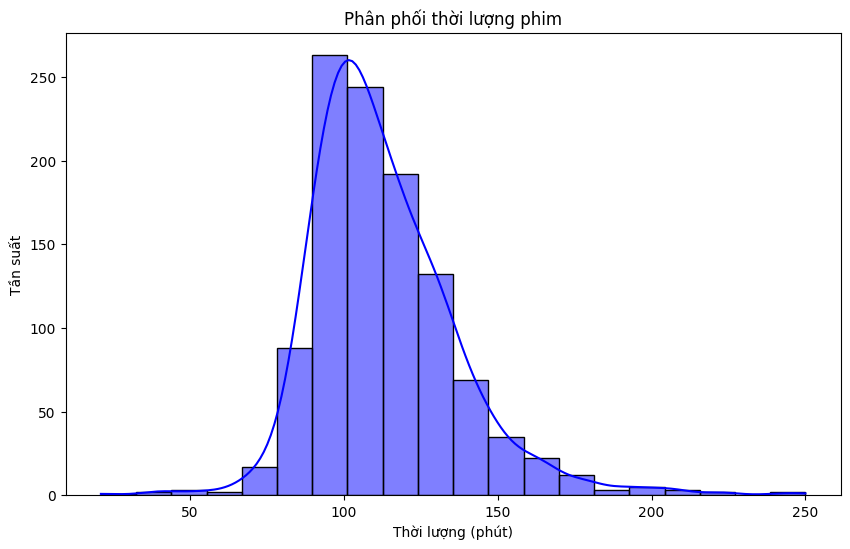

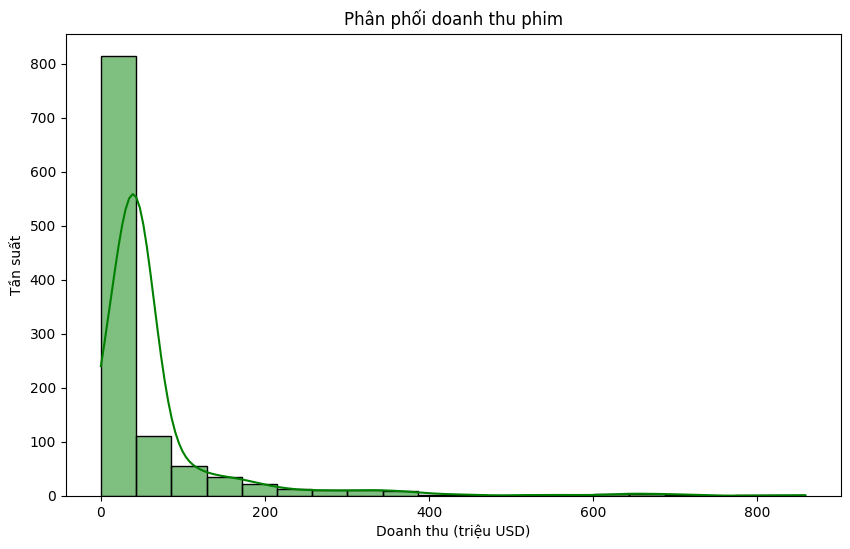

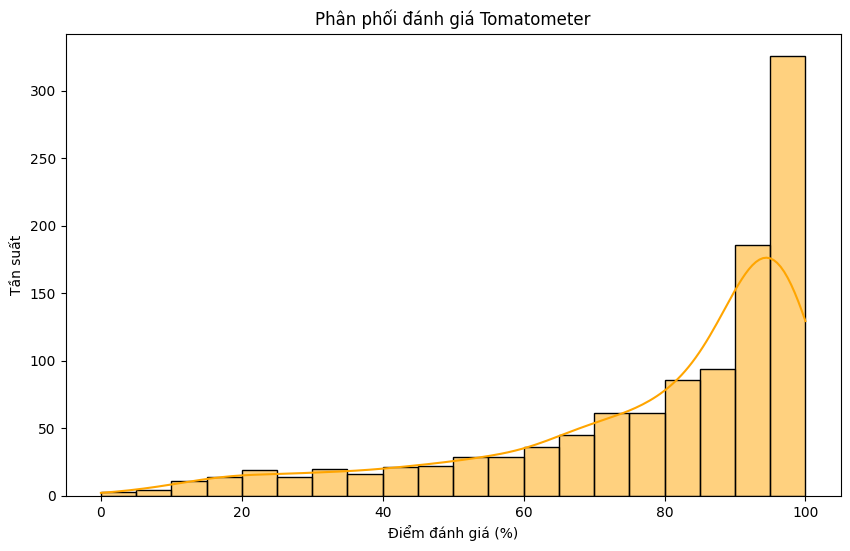

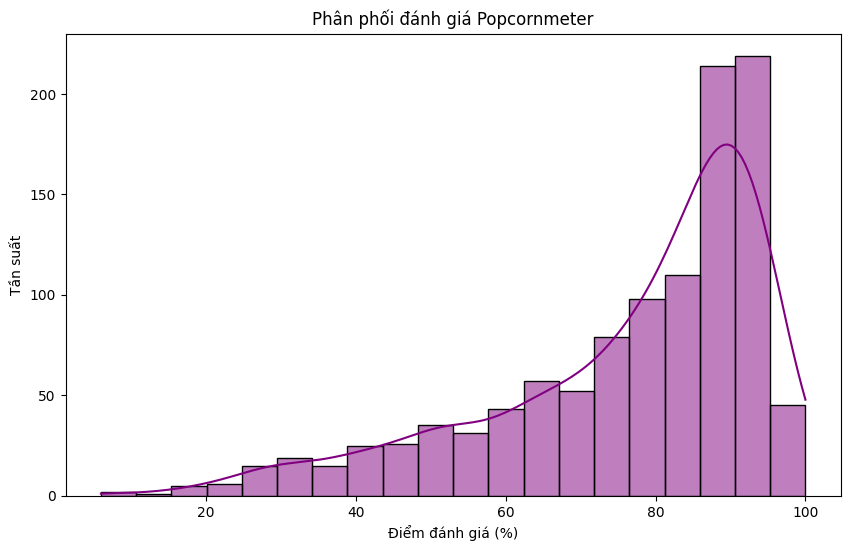

C:\Users\huyma\AppData\Local\Temp\ipykernel_20704\948560763.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


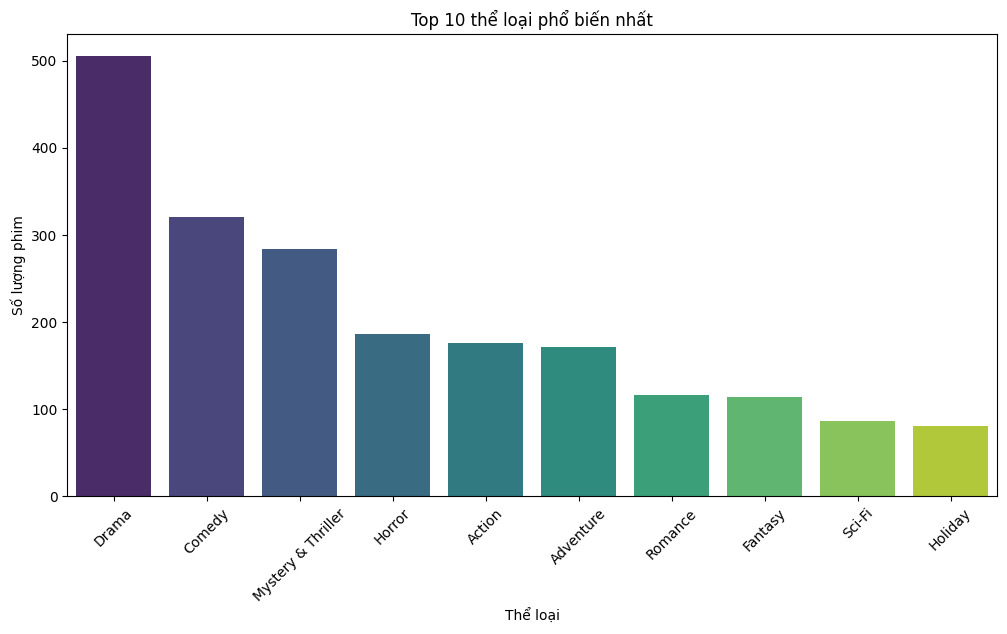

In [24]:
# 1. Phân phối thời lượng phim (`Runtime`)
plt.figure(figsize=(10, 6))
sns.histplot(data["Runtime"], kde=True, bins=20, color="blue")
plt.title("Phân phối thời lượng phim")
plt.xlabel("Thời lượng (phút)")
plt.ylabel("Tần suất")
plt.show()

# 2. Phân phối doanh thu phim (`Box Office (Gross USA)`)
plt.figure(figsize=(10, 6))
sns.histplot(data["Box Office (Gross USA)"], kde=True, bins=20, color="green")
plt.title("Phân phối doanh thu phim")
plt.xlabel("Doanh thu (triệu USD)")
plt.ylabel("Tần suất")
plt.show()

# 3. Phân phối đánh giá `Tomatometer`
plt.figure(figsize=(10, 6))
sns.histplot(data["Tomatometer"], kde=True, bins=20, color="orange")
plt.title("Phân phối đánh giá Tomatometer")
plt.xlabel("Điểm đánh giá (%)")
plt.ylabel("Tần suất")
plt.show()

# 4. Phân phối đánh giá `Popcornmeter`
plt.figure(figsize=(10, 6))
sns.histplot(data["Popcornmeter"], kde=True, bins=20, color="purple")
plt.title("Phân phối đánh giá Popcornmeter")
plt.xlabel("Điểm đánh giá (%)")
plt.ylabel("Tần suất")
plt.show()

# 5. Phân phối thể loại phim (`Genre`)
# Tách và đếm tất cả các thể loại
all_genres = [genre for genres in data["Genre"] for genre in genres]
genre_count = Counter(all_genres)

# Biểu đồ thể loại phổ biến
plt.figure(figsize=(12, 6))
sns.barplot(
    x=[genre[0] for genre in genre_count.most_common(10)],
    y=[genre[1] for genre in genre_count.most_common(10)],
    palette="viridis",
)
plt.title("Top 10 thể loại phổ biến nhất")
plt.xlabel("Thể loại")
plt.ylabel("Số lượng phim")
plt.xticks(rotation=45)
plt.show()

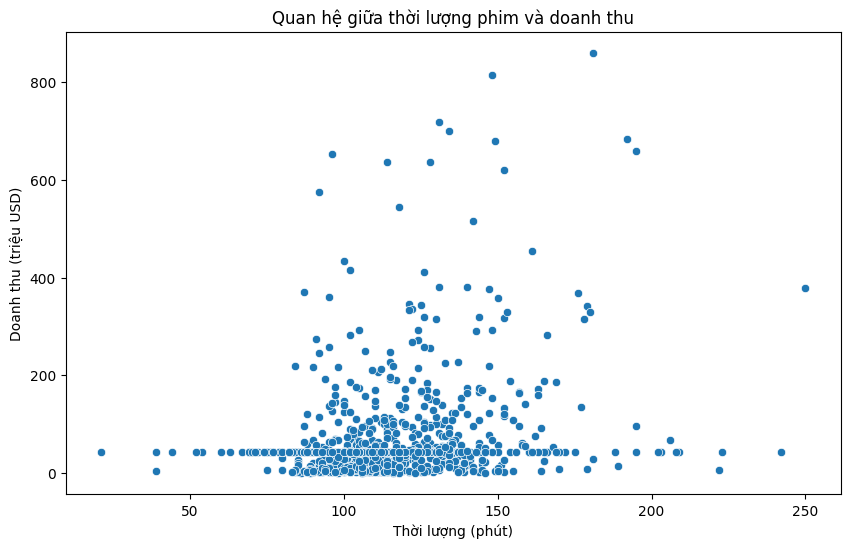

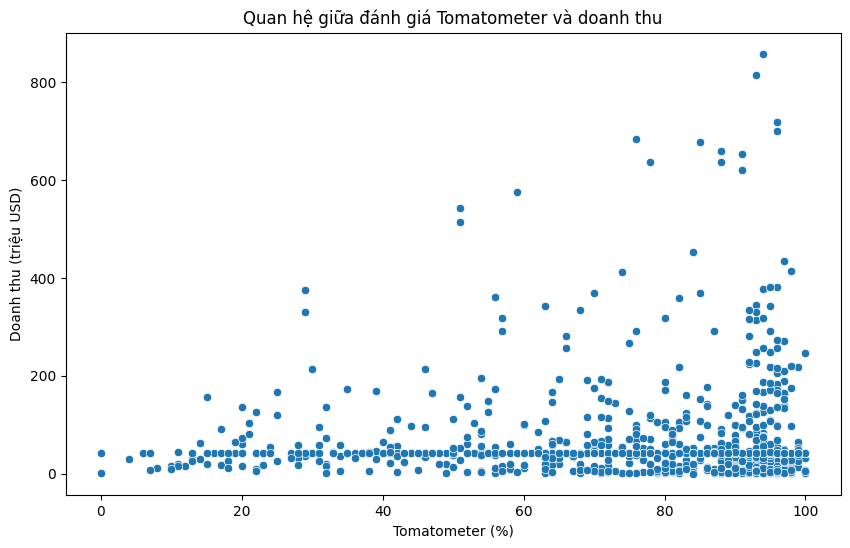

In [25]:
# Quan hệ giữa Runtime và Box Office
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data["Runtime"], y=data["Box Office (Gross USA)"])
plt.title("Quan hệ giữa thời lượng phim và doanh thu")
plt.xlabel("Thời lượng (phút)")
plt.ylabel("Doanh thu (triệu USD)")
plt.show()

# Quan hệ giữa Tomatometer và Box Office
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data["Tomatometer"], y=data["Box Office (Gross USA)"])
plt.title("Quan hệ giữa đánh giá Tomatometer và doanh thu")
plt.xlabel("Tomatometer (%)")
plt.ylabel("Doanh thu (triệu USD)")
plt.show()

In [26]:
from collections import Counter

# Đếm số lần xuất hiện của từng diễn viên
all_cast = [actor for cast in data["Cast"] for actor in cast]
cast_count = Counter(all_cast)

# Hiển thị top 10 diễn viên phổ biến nhất
top_cast = cast_count.most_common(10)
print("Top 10 diễn viên phổ biến nhất:", top_cast)

# Đếm số lần xuất hiện của từng thể loại
all_genres = [genre for genres in data["Genre"] for genre in genres]
genre_count = Counter(all_genres)

# Hiển thị top 10 thể loại phổ biến nhất
top_genres = genre_count.most_common(10)
print("Top 10 thể loại phổ biến nhất:", top_genres)

Top 10 diễn viên phổ biến nhất: [('Tom Hanks', 13), ('Matt Damon', 11), ('Ralph Fiennes', 10), ('Robert De Niro', 9), ('Christian Bale', 9), ('Timothée Chalamet', 9), ('Tom Cruise', 9), ('Willem Dafoe', 8), ('Adam Driver', 8), ('J.K. Simmons', 8)]
Top 10 thể loại phổ biến nhất: [('Drama', 505), ('Comedy', 321), ('Mystery & Thriller', 284), ('Horror', 186), ('Action', 176), ('Adventure', 171), ('Romance', 116), ('Fantasy', 114), ('Sci-Fi', 86), ('Holiday', 81)]


In [27]:
import networkx as nx

# Xây dựng đồ thị cộng tác diễn viên
actor_graph = nx.Graph()

for cast in data["Cast"]:
    for i, actor1 in enumerate(cast):
        for actor2 in cast[i + 1 :]:
            if actor_graph.has_edge(actor1, actor2):
                actor_graph[actor1][actor2]["weight"] += 1
            else:
                actor_graph.add_edge(actor1, actor2, weight=1)

# Hiển thị thông tin đồ thị
print(f"Số lượng nút (diễn viên): {actor_graph.number_of_nodes()}")
print(f"Số lượng cạnh (mối quan hệ): {actor_graph.number_of_edges()}")

Số lượng nút (diễn viên): 3841
Số lượng cạnh (mối quan hệ): 10682


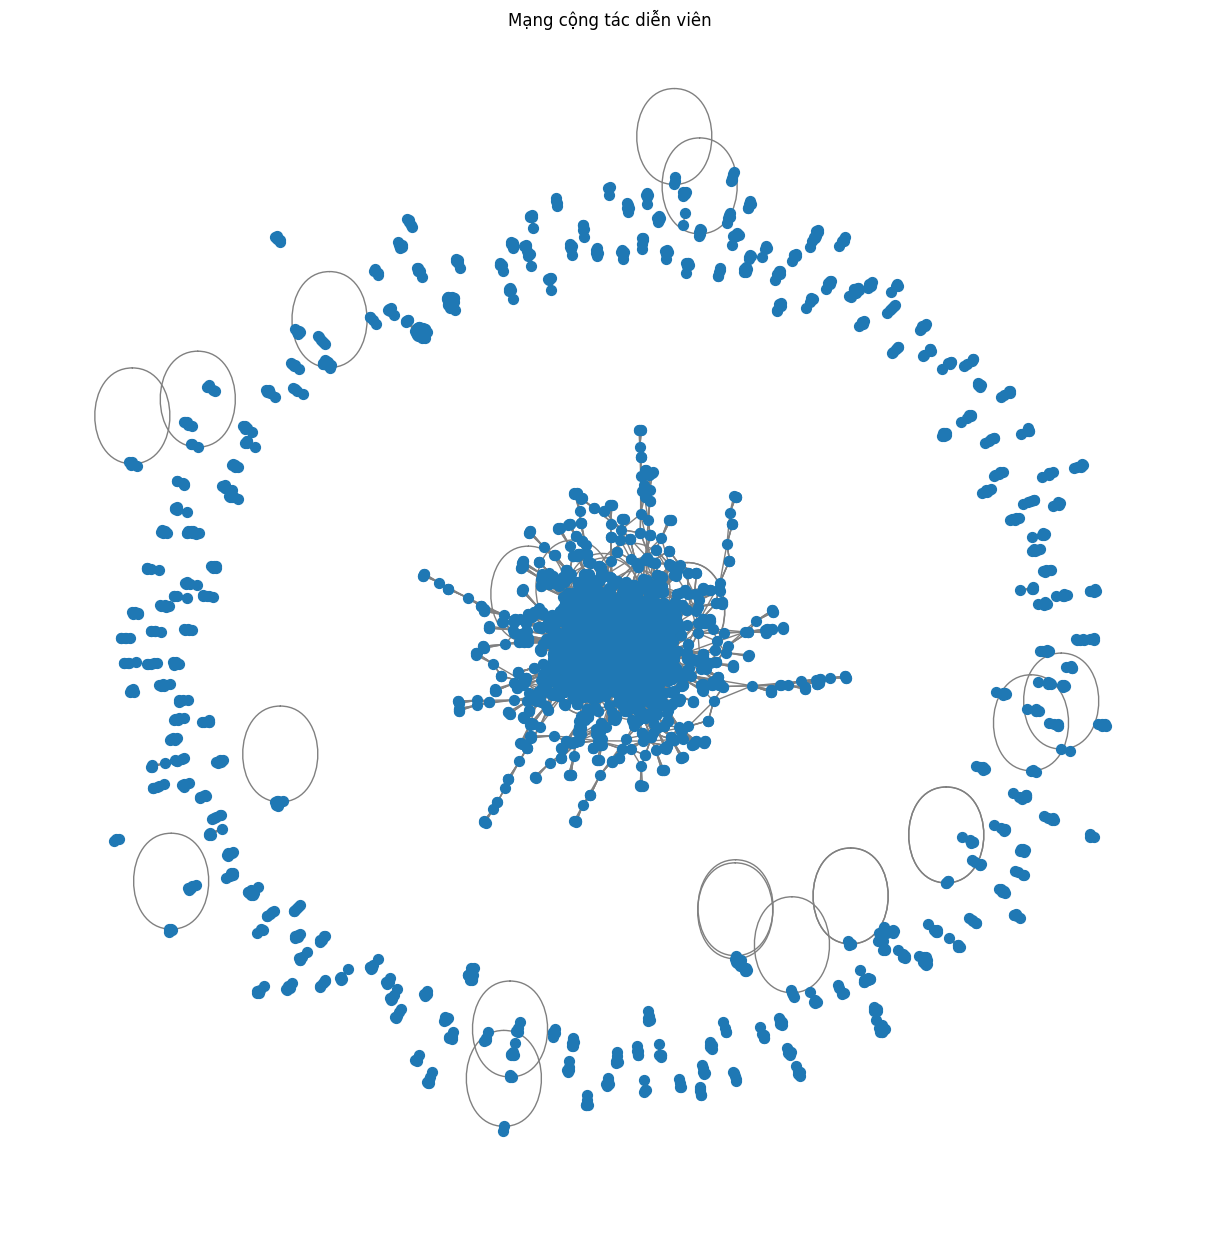

In [28]:
# Vẽ đồ thị cộng tác diễn viên
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(actor_graph, seed=42)
nx.draw(actor_graph, pos, with_labels=False, node_size=50, edge_color="gray")
plt.title("Mạng cộng tác diễn viên")
plt.show()

Số lượng nút trong thành phần lớn nhất: 2724
Số lượng cạnh trong thành phần lớn nhất: 8416


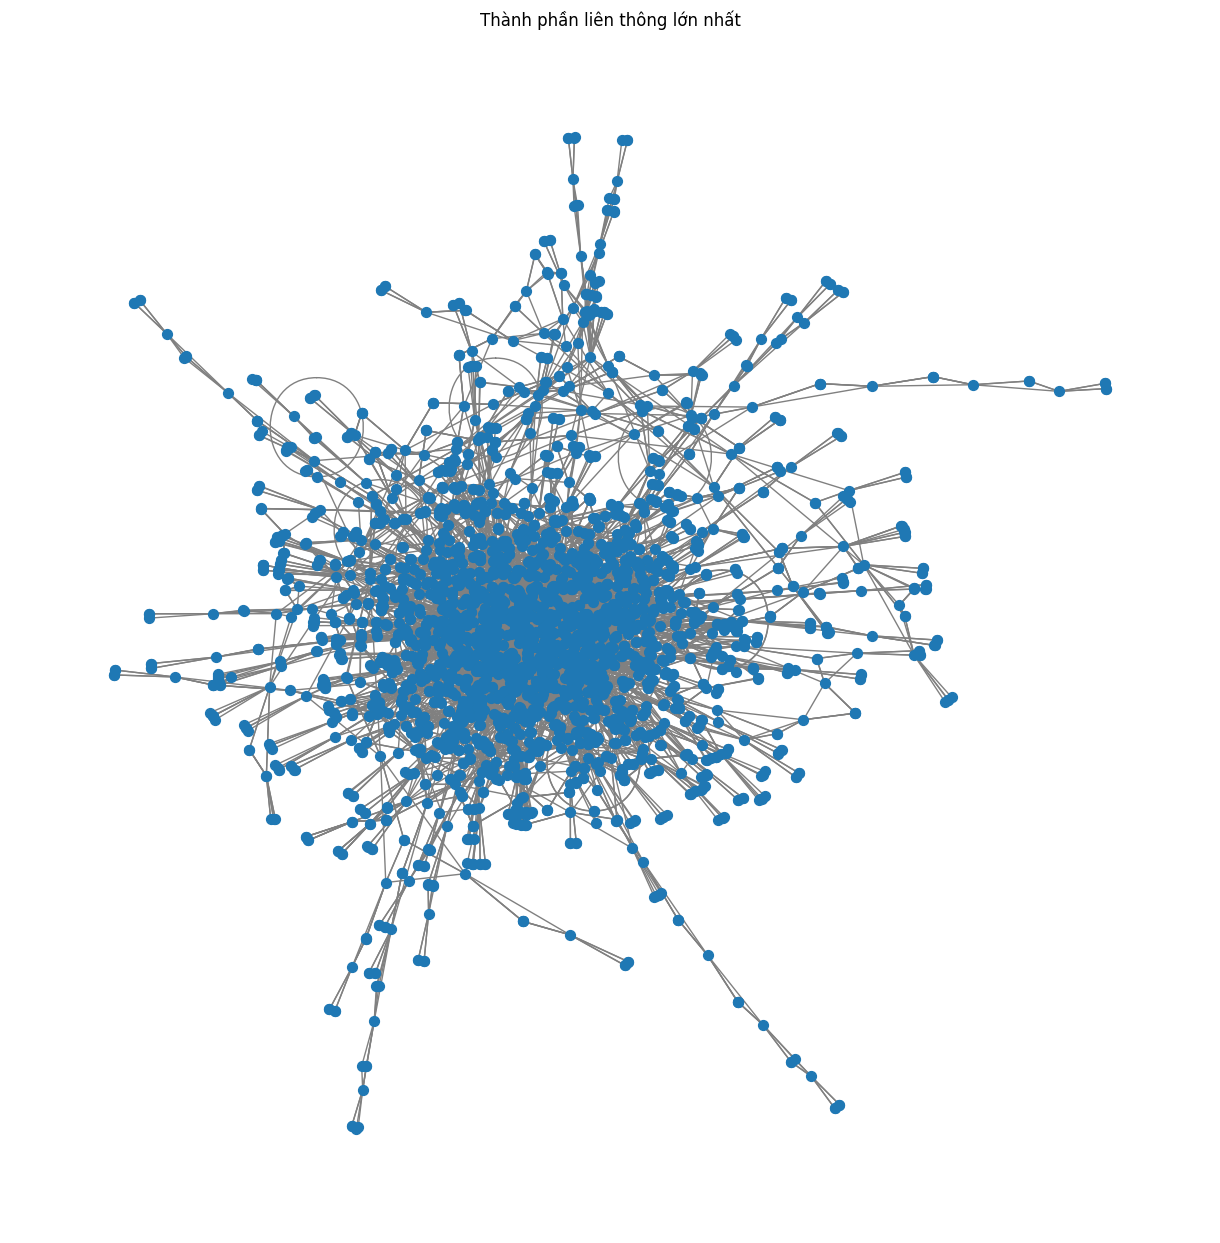

In [29]:
# Tìm thành phần liên thông lớn nhất
largest_component = max(nx.connected_components(actor_graph), key=len)

# Tạo đồ thị con chứa thành phần lớn nhất
subgraph = actor_graph.subgraph(largest_component).copy()

# Hiển thị thông tin
print(f"Số lượng nút trong thành phần lớn nhất: {subgraph.number_of_nodes()}")
print(f"Số lượng cạnh trong thành phần lớn nhất: {subgraph.number_of_edges()}")

# Vẽ lại mạng
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=False, node_size=50, edge_color="gray")
plt.title("Thành phần liên thông lớn nhất")
plt.show()

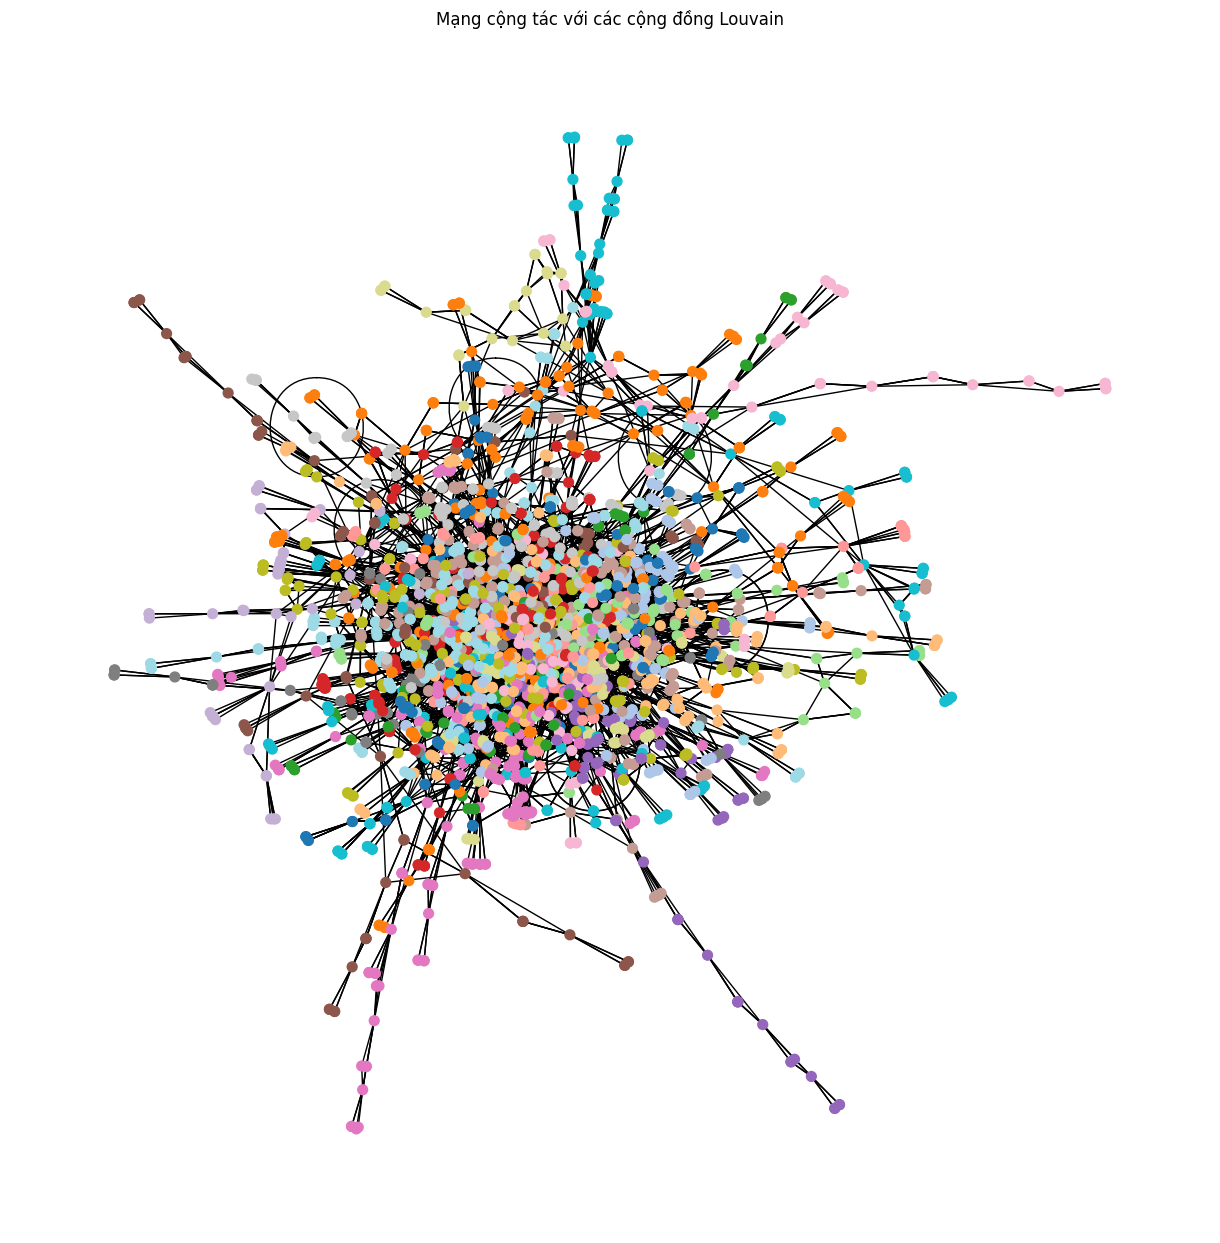

Số lượng cộng đồng: 37


In [30]:
from networkx.algorithms.community import louvain_communities

# Áp dụng thuật toán Louvain để phát hiện cộng đồng
communities = louvain_communities(subgraph, weight="weight")

# Ánh xạ màu sắc cho các cộng đồng
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Gán màu cho các nút
node_colors = [community_map[node] for node in subgraph.nodes()]

# Vẽ mạng với các cộng đồng
plt.figure(figsize=(12, 12))
nx.draw(
    subgraph,
    pos,
    node_color=node_colors,
    with_labels=False,
    node_size=50,
    cmap=plt.cm.tab20,
)
plt.title("Mạng cộng tác với các cộng đồng Louvain")
plt.show()

# In số lượng cộng đồng
print(f"Số lượng cộng đồng: {len(communities)}")

In [31]:
# Tính độ trung tâm
degree_centrality = nx.degree_centrality(subgraph)

# Tính độ trung gian
betweenness_centrality = nx.betweenness_centrality(subgraph)

# Tìm nút quan trọng nhất
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness = sorted(
    betweenness_centrality.items(), key=lambda x: x[1], reverse=True
)[:5]

print("Top 5 nút có độ trung tâm cao nhất:", top_degree)
print("Top 5 nút có độ trung gian cao nhất:", top_betweenness)

Top 5 nút có độ trung tâm cao nhất: [('Tom Hanks', 0.017260374586852735), ('Ralph Fiennes', 0.014322438486962907), ('Matt Damon', 0.014322438486962907), ('Christian Bale', 0.012118986412045537), ('Timothée Chalamet', 0.012118986412045537)]
Top 5 nút có độ trung gian cao nhất: [('Cary Grant', 0.05944587566654462), ('James Stewart', 0.05734449183448574), ('Marlon Brando', 0.05277885330281483), ('Jamie Lee Curtis', 0.0516970525041103), ('Harrison Ford', 0.046667829119690134)]


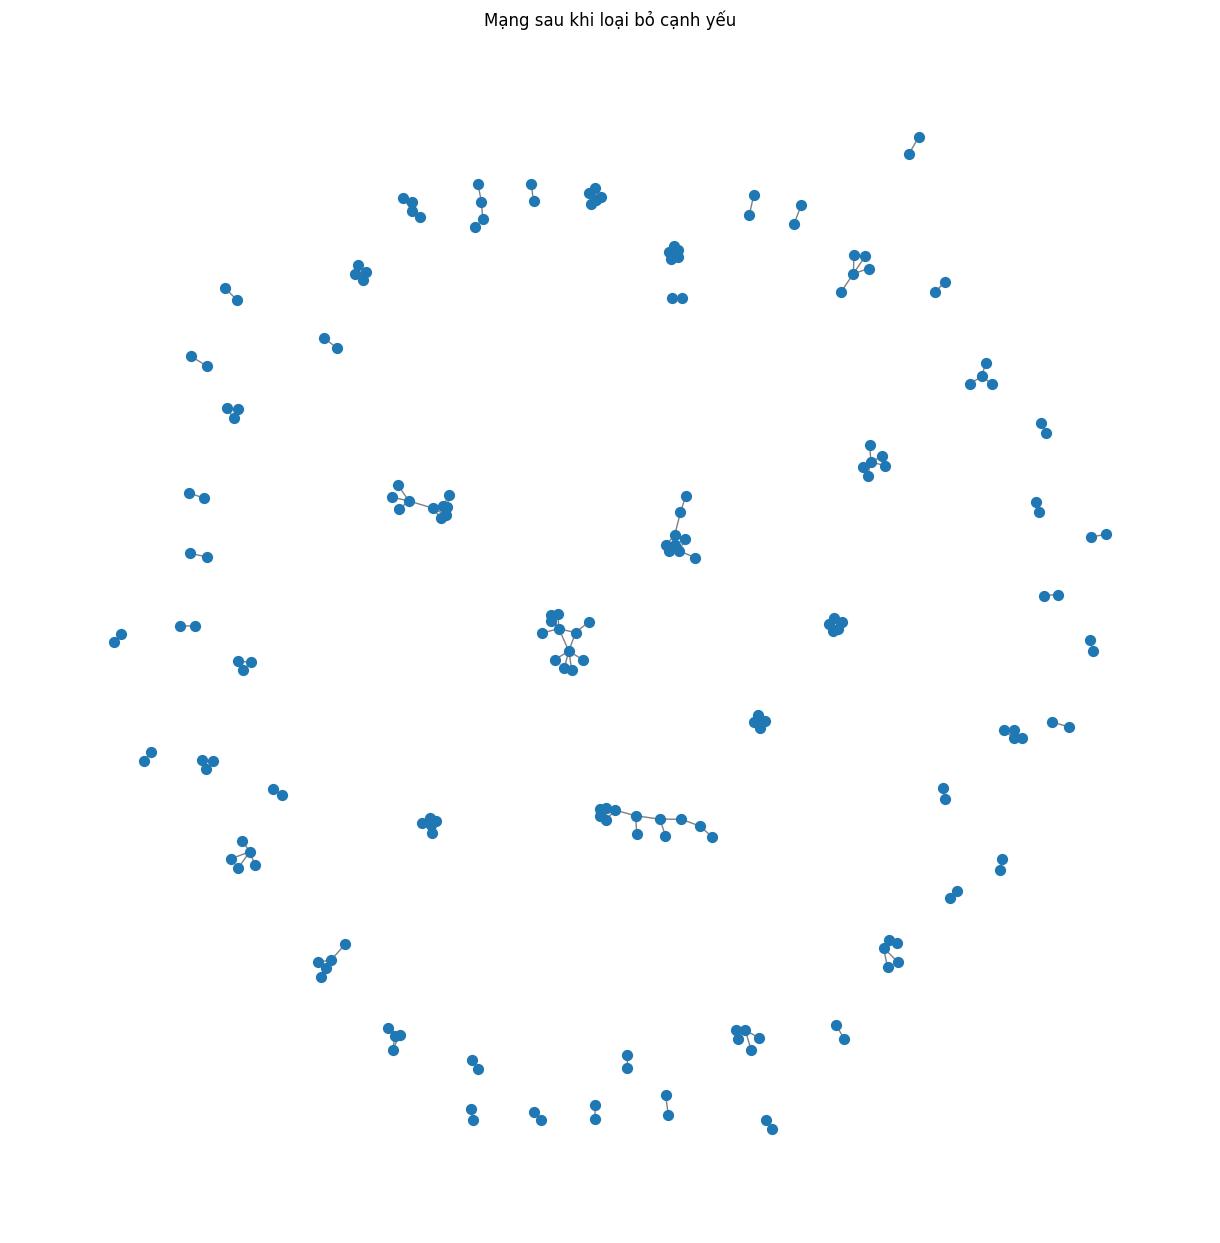

In [32]:
# Loại bỏ các cạnh có trọng số thấp (dưới ngưỡng 2)
threshold = 2
filtered_graph = nx.Graph(
    ((u, v, d) for u, v, d in subgraph.edges(data=True) if d["weight"] >= threshold)
)

# Vẽ lại mạng sau khi loại bỏ cạnh yếu
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(filtered_graph, seed=42)
nx.draw(filtered_graph, pos, with_labels=False, node_size=50, edge_color="gray")
plt.title("Mạng sau khi loại bỏ cạnh yếu")
plt.show()

In [33]:
# In danh sách các cộng đồng
for i, community in enumerate(communities):
    print(f"Cộng đồng {i+1}: {len(community)} nút")
    print(community)

Cộng đồng 1: 44 nút
{'John Magaro', 'Megan Stevenson', 'Sheb Wooley', 'Dennis Hopper', 'Matthew Del Negro', 'Yim Seung-min', 'Dennis Christopher', 'Sarah Paulson', 'Sophia Reid-Gantzert', 'Willa Fitzgerald', 'Dylan Baker', 'Neil Patrick Harris', 'Jon Tenney', 'Naomi Scott', 'Ed Begley Jr.', 'Jessie T. Usher', 'Thomas Dekker', 'Katie Cassidy', 'Rosemarie DeWitt', 'Lukas Gage', 'Steve Zahn', 'Fern Persons', 'Cate Blanchett', 'Dylan Walsh', 'Margo Martindale', 'Greta Lee', 'Sosie Bacon', 'Barbara Barrie', 'Miles Gutierrez-Riley', 'Sela Ward', 'Penn Badgley', 'Steven Michael Quezada', 'June Diane Raphael', 'Robin Weigert', 'Seung-ah Moon', 'Winslow Fegley', 'Amber Heard', 'Jake Lacy', 'Rooney Mara', 'Kyle Gallner', 'Barbara Hershey', 'Caitlin Stasey', 'Jackie Earle Haley', 'Teo Yoo'}
Cộng đồng 2: 88 nút
{'Brandon Perea', 'Anja Plaschg', 'Daniel Kaluuya', 'Veronika Franz', 'Julianne Nicholson', 'Ed Skrein', 'Jessica Clement', 'Sophie Okonedo', 'Jamie Lee Curtis', 'Kirby', 'Joanna Page', 'Zo

In [34]:
import networkx as nx
from networkx.algorithms.community import (
    greedy_modularity_communities,
    asyn_lpa_communities,
)
from networkx.algorithms.community import modularity

# 1. **Girman-Newman Algorithm** (Greedy Modularity Communities)
# Phân cụm bằng thuật toán Girman-Newman
gn_communities = list(greedy_modularity_communities(subgraph))

# Tính modularity cho Girman-Newman
gn_modularity = modularity(subgraph, gn_communities)

# 2. **Label Propagation Algorithm (LPA)**
# Phân cụm bằng thuật toán LPA
lpa_communities = list(asyn_lpa_communities(subgraph))

# Tính modularity cho LPA
lpa_modularity = modularity(subgraph, lpa_communities)

# 3. In kết quả modularity cho cả hai thuật toán
print(f"Modularity của Girman-Newman: {gn_modularity:.4f}")
print(f"Modularity của LPA: {lpa_modularity:.4f}")

# Số lượng cụm cho mỗi thuật toán
print(f"Số lượng cộng đồng (Girman-Newman): {len(gn_communities)}")
print(f"Số lượng cộng đồng (LPA): {len(lpa_communities)}")

Modularity của Girman-Newman: 0.7092
Modularity của LPA: 0.5760
Số lượng cộng đồng (Girman-Newman): 78
Số lượng cộng đồng (LPA): 527


In [35]:
from networkx.algorithms.community import louvain_communities

# 3. **Louvain Algorithm**
# Phân cụm bằng thuật toán Louvain
louvain_communities_result = list(louvain_communities(subgraph, weight="weight"))

# Tính modularity cho Louvain
louvain_modularity = modularity(subgraph, louvain_communities_result)

# In kết quả modularity và số lượng cộng đồng
print(f"Modularity của Louvain: {louvain_modularity:.4f}")
print(f"Số lượng cộng đồng (Louvain): {len(louvain_communities_result)}")

Modularity của Louvain: 0.7708
Số lượng cộng đồng (Louvain): 37


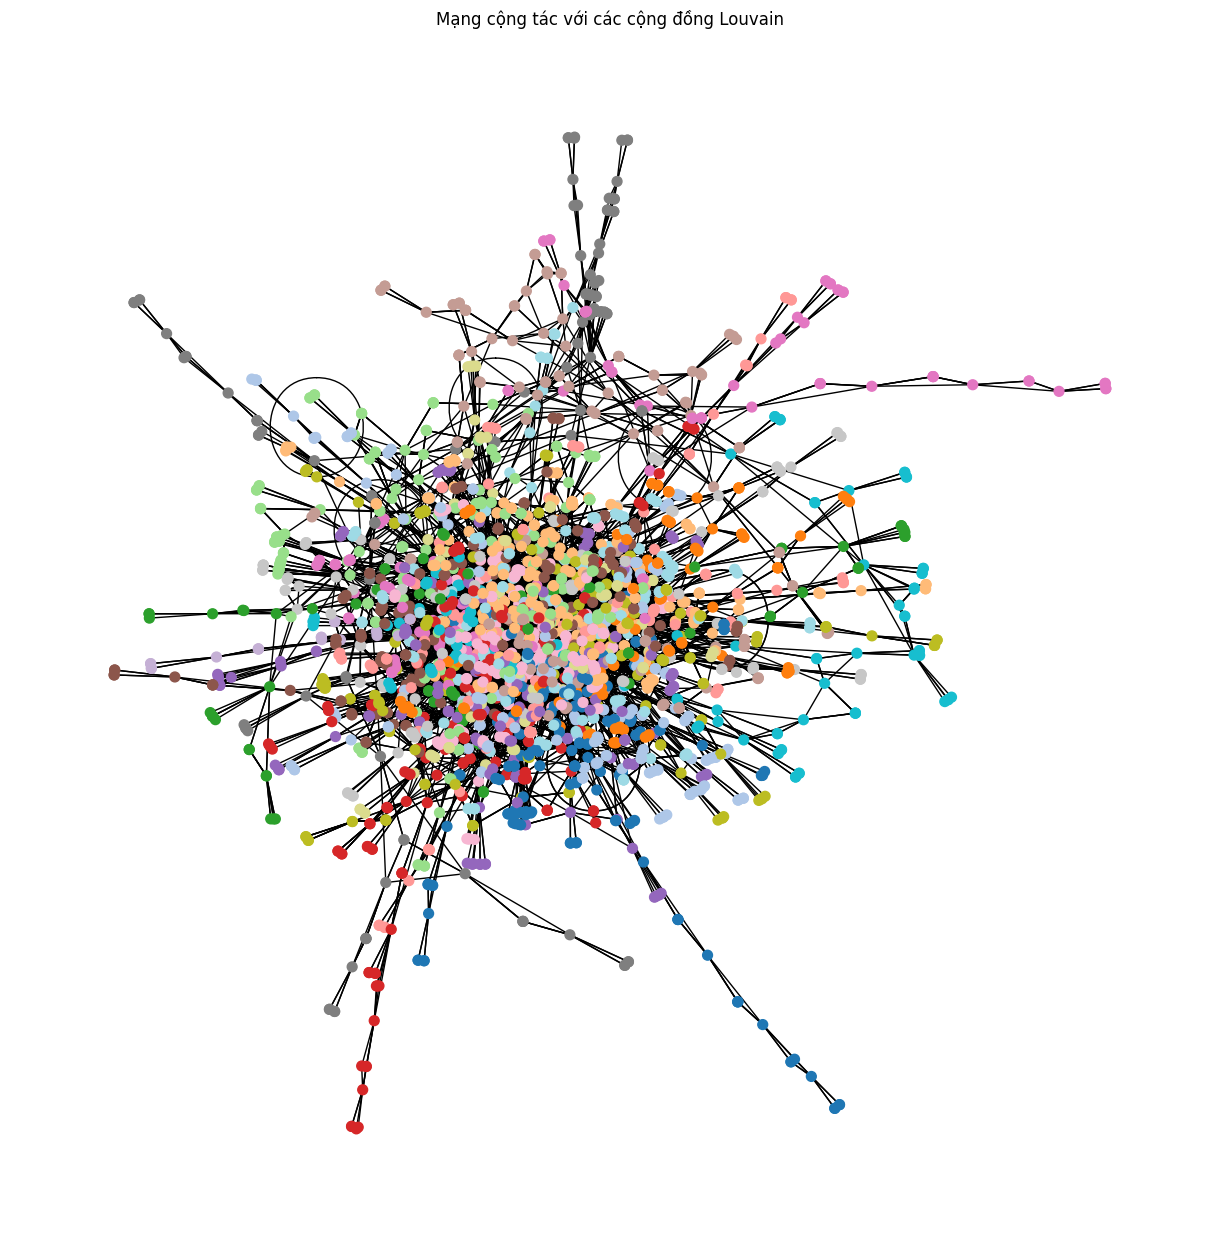

In [36]:
import matplotlib.pyplot as plt

# Ánh xạ cộng đồng thành màu sắc
community_map = {}
for i, community in enumerate(louvain_communities_result):
    for node in community:
        community_map[node] = i

node_colors = [community_map[node] for node in subgraph.nodes()]

# Vẽ đồ thị
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(
    subgraph,
    pos,
    node_color=node_colors,
    with_labels=False,
    node_size=50,
    cmap=plt.cm.tab20,
)
plt.title("Mạng cộng tác với các cộng đồng Louvain")
plt.show()

In [37]:
for i, community in enumerate(louvain_communities_result):
    community_subgraph = subgraph.subgraph(community)
    degree_centrality = nx.degree_centrality(community_subgraph)
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"Cộng đồng {i+1} - Top 5 nút có độ trung tâm cao nhất:")
    print(top_degree)

Cộng đồng 1 - Top 5 nút có độ trung tâm cao nhất:
[('Shia LaBeouf', 0.26666666666666666), ('Aubrey Plaza', 0.18333333333333332), ('Dakota Johnson', 0.15), ('Elisha Cuthbert', 0.13333333333333333), ('Eoin Macken', 0.13333333333333333)]
Cộng đồng 2 - Top 5 nút có độ trung tâm cao nhất:
[('Ethan Hawke', 0.24489795918367346), ('Michael Caine', 0.17346938775510204), ('Anne Hathaway', 0.13265306122448978), ('Jeremy Strong', 0.11224489795918366), ('Matthew McConaughey', 0.11224489795918366)]
Cộng đồng 3 - Top 5 nút có độ trung tâm cao nhất:
[('Matthew Broderick', 0.17567567567567569), ('Bruce Willis', 0.16216216216216217), ('Jeremy Irons', 0.14864864864864866), ('Bonnie Bedelia', 0.13513513513513514), ('John Cleese', 0.12162162162162163)]
Cộng đồng 4 - Top 5 nút có độ trung tâm cao nhất:
[('Harris Dickinson', 0.1619047619047619), ('Glen Powell', 0.1523809523809524), ('Antonio Banderas', 0.14285714285714288), ('Nicole Kidman', 0.12380952380952381), ('Dolly De Leon', 0.12380952380952381)]
Cộng 

c:\thaiduong\tduong\lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


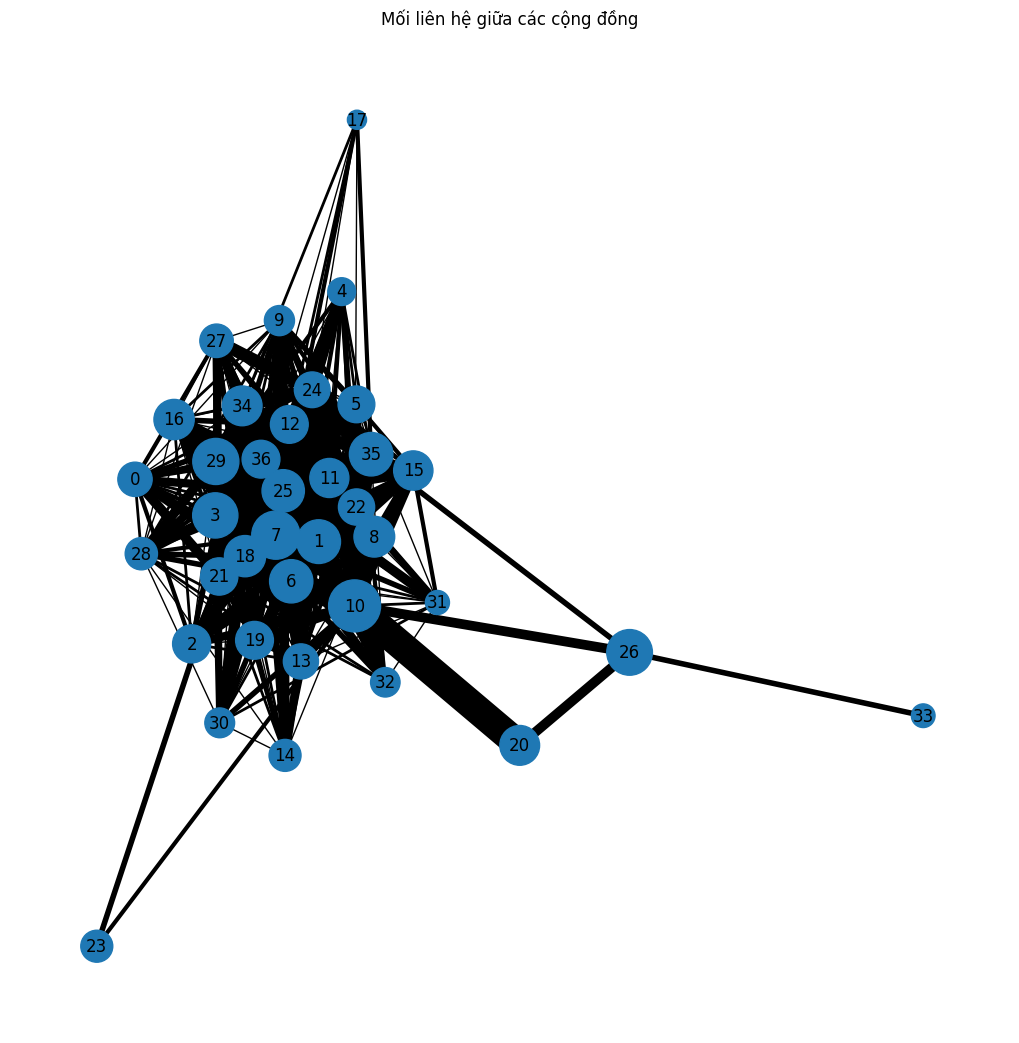

In [38]:
# Tạo đồ thị thu gọn
community_graph = nx.Graph()

for i, community in enumerate(louvain_communities_result):
    community_graph.add_node(i, size=len(community))

for i, community1 in enumerate(louvain_communities_result):
    for j, community2 in enumerate(louvain_communities_result):
        if i < j:
            edge_weight = sum(
                1
                for node1 in community1
                for node2 in community2
                if subgraph.has_edge(node1, node2)
            )
            if edge_weight > 0:
                community_graph.add_edge(i, j, weight=edge_weight)

# Vẽ đồ thị thu gọn
pos = nx.spring_layout(community_graph, seed=42)
sizes = [community_graph.nodes[node]["size"] * 10 for node in community_graph.nodes()]
weights = [d["weight"] for _, _, d in community_graph.edges(data=True)]

plt.figure(figsize=(10, 10))
nx.draw(
    community_graph,
    pos,
    with_labels=True,
    node_size=sizes,
    width=weights,
    cmap=plt.cm.Blues,
)
plt.title("Mối liên hệ giữa các cộng đồng")
plt.show()

In [39]:
# Xem thông tin chi tiết về các cộng đồng lớn
for i in [0, 6, 1, 7]:
    print(f"Cộng đồng {i} (số nút: {len(louvain_communities_result[i])}):")
    print(louvain_communities_result[i])

Cộng đồng 0 (số nút: 61):
{'Amy Madigan', 'Courtney Taylor', 'Callan Mulvey', 'Eve Hewson', 'Tara Lee', 'Clé Bennett', 'Jared Padalecki', 'Brian Van Holt', 'Aubrey Plaza', 'Jonathan Avigdori', 'Elisha Cuthbert', 'Aml Ameen', 'Stacy Martin', 'Dylan Fitzmaurice Brady', 'Alana Boden', 'Michael Schwartz', 'Eoin Macken', 'Tyrese Gibson', 'Scott Eastwood', 'Eloise Mumford', 'Josh Duhamel', 'Gérard Depardieu', 'Britt Robertson', 'Paris Hilton', 'Thomas Doherty', 'Marla Sokoloff', 'Timothy Hutton', 'Nathalie Emmanuel', 'Shia LaBeouf', 'Kim Yarbrough', 'Marc Anthony Samuel', 'Gaby Hoffmann', 'Stellan Skarsgård', 'Chad Michael Murray', 'Megan Fox', 'Maddie Ziegler', 'Christian Slater', 'Tyler Nilson', 'Megalyn Echikunwoke', 'Zack Gottsagen', 'Jennifer Ehle', 'John Hawkes', 'Maisy Stella', 'Charlotte Gainsbourg', 'Theo Rossi', 'LL Cool J', 'Colt Prattes', 'Stephanie Corneliussen', 'Dakota Johnson', 'Giancarlo Esposito', 'Jonas Karlsson', 'Abby Fitz', 'Dylan Arnold', 'Jamie Dornan', 'Victor Rasuk'